In [1]:
# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession
# Create my_spark
spark = SparkSession.builder.getOrCreate()
# load ratings data
df = spark.read.csv("2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)

In [2]:
df.printSchema()

root
 |-- No.: integer (nullable = true)
 |-- MLSID: string (nullable = true)
 |-- StreetNumberNumeric: integer (nullable = true)
 |-- streetaddress: string (nullable = true)
 |-- STREETNAME: string (nullable = true)
 |-- PostalCode: integer (nullable = true)
 |-- StateOrProvince: string (nullable = true)
 |-- City: string (nullable = true)
 |-- SalesClosePrice: integer (nullable = true)
 |-- LISTDATE: string (nullable = true)
 |-- LISTPRICE: integer (nullable = true)
 |-- LISTTYPE: string (nullable = true)
 |-- OriginalListPrice: integer (nullable = true)
 |-- PricePerTSFT: double (nullable = true)
 |-- FOUNDATIONSIZE: integer (nullable = true)
 |-- FENCE: string (nullable = true)
 |-- MapLetter: string (nullable = true)
 |-- LotSizeDimensions: string (nullable = true)
 |-- SchoolDistrictNumber: string (nullable = true)
 |-- DAYSONMARKET: integer (nullable = true)
 |-- offmarketdate: string (nullable = true)
 |-- Fireplaces: integer (nullable = true)
 |-- RoomArea4: string (nullable =

# Dropping a list of columns

In [3]:
# List of columns to remove from dataset
cols_to_drop = ['No.','STREETNUMBERNUMERIC', 'LOTSIZEDIMENSIONS']

# Drop columns in list
df = df.drop(*cols_to_drop)

# Using text filters to remove records

In [4]:
# Inspect unique values in the column 'ASSUMABLEMORTGAGE'
df.select(['ASSUMABLEMORTGAGE']).distinct().show()

+-------------------+
|  ASSUMABLEMORTGAGE|
+-------------------+
|  Yes w/ Qualifying|
| Information Coming|
|               null|
|Yes w/No Qualifying|
|      Not Assumable|
+-------------------+



In [5]:
# List of possible values containing 'yes'
yes_values = ['Yes w/ Qualifying', 'Yes w/No Qualifying']

# Filter the text values out of df but keep null values
text_filter = ~df['ASSUMABLEMORTGAGE'].isin(yes_values) | df['ASSUMABLEMORTGAGE'].isNull()
df = df.where(text_filter)

# Print count of remaining records
print(df.count())

4976


In [6]:
from pyspark.sql.functions import log10
df = df.withColumn('log_SalesClosePrice', log10(df['SalesClosePrice']))
df[['log_SalesClosePrice']].show()

+-------------------+
|log_SalesClosePrice|
+-------------------+
|  5.155336037465061|
|  5.278753600952829|
|  5.352182518111363|
|  5.423245873936808|
|   5.39776625612645|
| 5.4065401804339555|
|  5.394451680826216|
|  5.389166084364533|
|  5.406523148943849|
| 5.3979400086720375|
|  5.405687786672778|
| 5.4031205211758175|
| 5.4107772333772095|
|   5.43614673852661|
| 5.4623979978989565|
|  5.437750562820388|
|  5.439316901016504|
|  5.437750562820388|
|  5.450249108319361|
| 5.4481139773928176|
+-------------------+
only showing top 20 rows



In [7]:
from pyspark.sql.functions import mean, stddev

# Calculate values used for outlier filtering
mean_val = df.agg({'log_SalesClosePrice': 'mean'}).collect()[0][0]
stddev_val = df.agg({'log_SalesClosePrice': 'stddev'}).collect()[0][0]

# Create three standard deviation (μ ± 3σ) lower and upper bounds for data
low_bound = mean_val - (3 * stddev_val)
hi_bound = mean_val + (3 * stddev_val)

# Filter the data to fit between the lower and upper bounds
df = df.where((df['log_SalesClosePrice'] < hi_bound) & (df['log_SalesClosePrice'] > low_bound))

In [8]:
from pyspark.sql.functions import round

# Define max and min values and collect them
max_days = df.agg({'DAYSONMARKET': 'max'}).collect()[0][0]
min_days = df.agg({'DAYSONMARKET': 'min'}).collect()[0][0]

# Create a new column based off the scaled data
df = df.withColumn('percentagescaleddays' , 
                  round((df['DAYSONMARKET'] - min_days) / (max_days - min_days)) * 100)

# Calc max and min for new column
print(df.agg({'percentagescaleddays': 'max'}).collect())
print(df.agg({'percentagescaleddays': 'min'}).collect())

[Row(max(percentagescaleddays)=100.0)]
[Row(min(percentagescaleddays)=0.0)]


In [9]:
df[['percentagescaleddays']].show()

+--------------------+
|percentagescaleddays|
+--------------------+
|                 0.0|
|                 0.0|
|                 0.0|
|                 0.0|
|                 0.0|
|                 0.0|
|                 0.0|
|                 0.0|
|                 0.0|
|                 0.0|
|                 0.0|
|                 0.0|
|                 0.0|
|                 0.0|
|                 0.0|
|                 0.0|
|                 0.0|
|                 0.0|
|                 0.0|
|                 0.0|
+--------------------+
only showing top 20 rows



In [10]:
cols_to_scale=['FOUNDATIONSIZE', 'DAYSONMARKET', 'FIREPLACES']
new_column_name = 'scaled_' + 'FOUNDATIONSIZE'
print(new_column_name)


scaled_FOUNDATIONSIZE


In [11]:
cols_to_scale=['FOUNDATIONSIZE', 'DAYSONMARKET', 'FIREPLACES']

def min_max_scaler(df, cols_to_scale):
  # Takes a dataframe and list of columns to minmax scale. Returns a dataframe.
    for col in cols_to_scale:
    # Define min and max values and collect them
        max_days = df.agg({col: 'max'}).collect()[0][0]
        min_days = df.agg({col: 'min'}).collect()[0][0]
        new_column_name = 'scaled_' + col
        # Create a new column based off the scaled data
        df = df.withColumn(new_column_name, 
                      (df[col] - min_days) / (max_days - min_days))
    return df
  
df = min_max_scaler(df, cols_to_scale)

In [12]:
# Show that our data is now between 0 and 1
df[['DAYSONMARKET', 'scaled_DAYSONMARKET']].show()

+------------+--------------------+
|DAYSONMARKET| scaled_DAYSONMARKET|
+------------+--------------------+
|          10|0.044444444444444446|
|           4|0.017777777777777778|
|          28| 0.12444444444444444|
|          19| 0.08444444444444445|
|          21| 0.09333333333333334|
|          17| 0.07555555555555556|
|          32| 0.14222222222222222|
|           5|0.022222222222222223|
|          23| 0.10222222222222223|
|          73|  0.3244444444444444|
|          80| 0.35555555555555557|
|          79|  0.3511111111111111|
|          12| 0.05333333333333334|
|           1|0.004444444444444...|
|          18|                0.08|
|           2|0.008888888888888889|
|          12| 0.05333333333333334|
|          45|                 0.2|
|          31| 0.13777777777777778|
|          16| 0.07111111111111111|
+------------+--------------------+
only showing top 20 rows



In [13]:
from pyspark.sql.functions import log

# Compute the skewness
print(df.agg({'YEARBUILT': 'skewness'}).collect())

# Calculate the max year
max_year = df.agg({'YEARBUILT': 'max'}).collect()[0][0]

# Create a new column of reflected data
df = df.withColumn('Reflect_YearBuilt', (max_year + 1) - df['YEARBUILT'])

# Create a new column based reflected data
df = df.withColumn('adj_yearbuilt', 1 / log(df['Reflect_YearBuilt']))

[Row(skewness(YEARBUILT)=-0.25317374723020336)]


In [14]:
columns=['APPLIANCES', 'BACKONMARKETDATE', 'ROOMFAMILYCHAR', 'BASEMENT', 'DININGROOMDESCRIPTION']

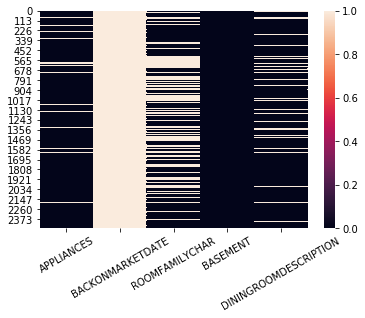

In [15]:
# Sample the dataframe and convert to Pandas
sample_df = df.select(columns).sample(False, 0.5, 42)
pandas_df = sample_df.toPandas()

# Convert all values to T/F
tf_df = pandas_df.isnull()
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
# Plot it
sns.heatmap(data=tf_df)
plt.xticks(rotation=30, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

# Set the answer to the column with the most missing data
answer = 'BACKONMARKETDATE'

# Imputing Missing Data

In [23]:
# Count missing rows
missing = df.where(df['PDOM'].isNull()).count()

# Calculate the mean value
col_mean = df.agg({'PDOM': 'mean'}).collect()[0][0]

# Replacing with the mean value for that column
df.fillna(col_mean, subset=['PDOM'])

DataFrame[MLSID: string, streetaddress: string, STREETNAME: string, PostalCode: int, StateOrProvince: string, City: string, SalesClosePrice: int, LISTDATE: string, LISTPRICE: int, LISTTYPE: string, OriginalListPrice: int, PricePerTSFT: double, FOUNDATIONSIZE: int, FENCE: string, MapLetter: string, SchoolDistrictNumber: string, DAYSONMARKET: int, offmarketdate: string, Fireplaces: int, RoomArea4: string, roomtype: string, ROOF: string, RoomFloor4: string, PotentialShortSale: string, PDOM: int, GarageDescription: string, SQFTABOVEGROUND: int, Taxes: int, RoomFloor1: string, RoomArea1: string, TAXWITHASSESSMENTS: double, TAXYEAR: int, LivingArea: int, YEARBUILT: int, ZONING: string, STYLE: string, ACRES: double, CoolingDescription: string, APPLIANCES: string, ROOMFAMILYCHAR: string, RoomArea3: string, EXTERIOR: string, RoomFloor3: string, RoomFloor2: string, RoomArea2: string, DiningRoomDescription: string, BASEMENT: string, BathsFull: int, BathsHalf: int, BATHQUARTER: int, BATHSTHREEQUAR

In [18]:
def column_dropper(df, threshold):
  # Takes a dataframe and threshold for missing values. Returns a dataframe.
    total_records = df.count()
    for col in df.columns:
    # Calculate the percentage of missing values
        missing = df.where(df[col].isNull()).count()
        missing_percent = missing / total_records
    # Drop column if percent of missing is more than threshold
        if missing_percent > threshold:
            df = df.drop(col)
    return df

# Drop columns that are more than 60% missing
df = column_dropper(df, 0.6)

In [19]:
df.printSchema()

root
 |-- MLSID: string (nullable = true)
 |-- streetaddress: string (nullable = true)
 |-- STREETNAME: string (nullable = true)
 |-- PostalCode: integer (nullable = true)
 |-- StateOrProvince: string (nullable = true)
 |-- City: string (nullable = true)
 |-- SalesClosePrice: integer (nullable = true)
 |-- LISTDATE: string (nullable = true)
 |-- LISTPRICE: integer (nullable = true)
 |-- LISTTYPE: string (nullable = true)
 |-- OriginalListPrice: integer (nullable = true)
 |-- PricePerTSFT: double (nullable = true)
 |-- FOUNDATIONSIZE: integer (nullable = true)
 |-- FENCE: string (nullable = true)
 |-- MapLetter: string (nullable = true)
 |-- SchoolDistrictNumber: string (nullable = true)
 |-- DAYSONMARKET: integer (nullable = true)
 |-- offmarketdate: string (nullable = true)
 |-- Fireplaces: integer (nullable = true)
 |-- RoomArea4: string (nullable = true)
 |-- roomtype: string (nullable = true)
 |-- ROOF: string (nullable = true)
 |-- RoomFloor4: string (nullable = true)
 |-- Potenti